In [50]:
import os
import random

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys

sys.path.append("generative_inpainting_pytorch")
from generative_inpainting_pytorch.model.networks import Generator
from generative_inpainting_pytorch.utils.tools import (
    get_config,
    is_image_file,
    default_loader,
    normalize,
    get_model_list,
)

In [51]:
# available classes for object removal
class ClassLabels:
    background = 0
    aeroplane = 1
    bicycle = 2
    bird = 3
    boat = 4
    bottle = 5
    bus = 6
    car = 7
    cat = 8
    chair = 9
    cow = 10
    diningtable = 11
    dog = 12
    horse = 13
    motorbike = 14
    person = 15
    pottedplant = 16
    sheep = 17
    sofa = 18
    train = 19
    tvmonitor = 20
    NUM_CLASSES = 21

config_file = "generative_inpainting_pytorch/configs/config.yaml"
config = get_config(config_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_dir = ""
images = [
    "test3.jpg",
    "test1.jpg",
    "test2.jpg",
]
target_classes = [ClassLabels.person, ClassLabels.cow, ClassLabels.cat]

# load in raw images
raw_imgs = []
original_sizes = []
resized_imgs = []
for i in range(len(images)):
    img_file = os.path.join(image_dir, images[i])
    assert is_image_file(img_file), f"{img_file} is not an image file"
    raw_img = default_loader(img_file)
    raw_imgs.append(raw_img)
    original_sizes.append(raw_img.size)
    resized_img = transforms.Resize(config["image_shape"][:-1])(raw_img)
    resized_imgs.append(resized_img)

## segmentation

In [52]:
# Load a pre-trained DeepLabV3 model
# `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights
model = models.segmentation.deeplabv3_resnet101(
    weights="DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1"
)
model.eval()
model.to(device)

seg_preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [66]:
input_tensors = []
for i in range(len(resized_imgs)):
    processed_tensor = seg_preprocess(resized_imgs[i])
    input_tensors.append(processed_tensor)

input_batch = torch.stack(input_tensors).to(device)

with torch.no_grad():
    output = model(input_batch)["out"]
output_predictions = output.argmax(1)  # Get predictions for each image in the batch

In [69]:
for i in range(len(target_classes)):
    print(f"Target class: {target_classes[i]}")
    for j in range(ClassLabels.NUM_CLASSES):
        temp = torch.all(output_predictions[i] != j)
        print(j, not temp)

Target class: 15
0 True
1 True
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 True
16 False
17 False
18 False
19 False
20 False
Target class: 10
0 True
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 True
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
Target class: 8
0 True
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 True
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False


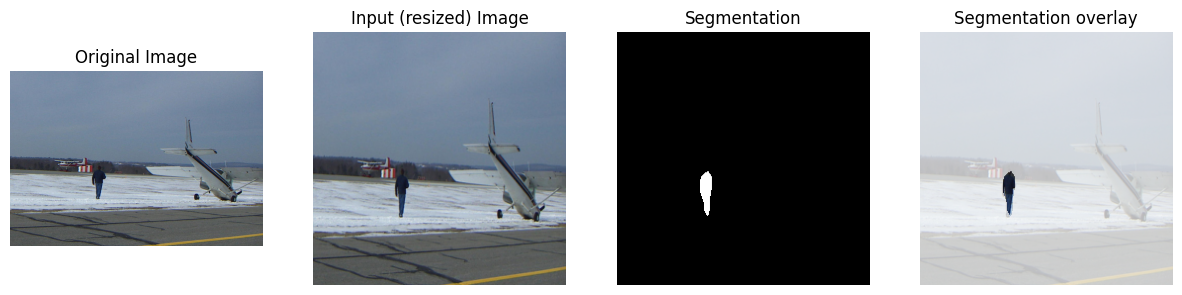

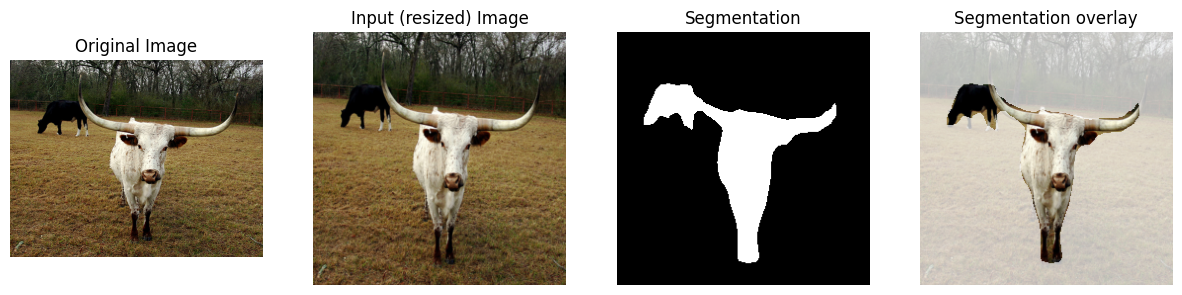

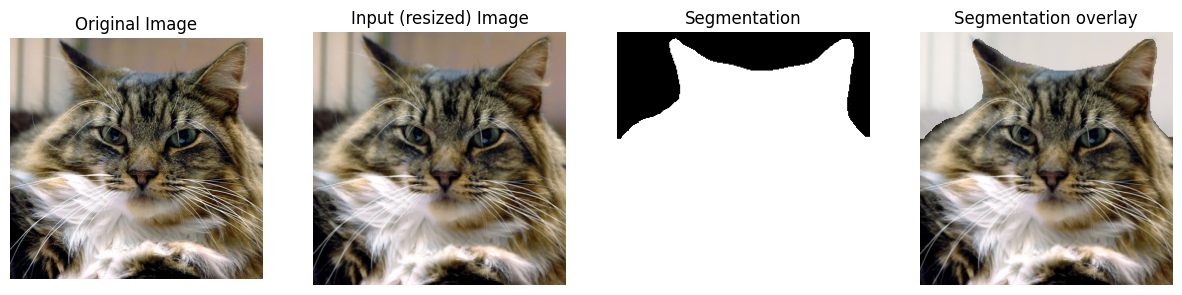

In [54]:
def get_masks_by_class(predictions, target_class=15):
    if isinstance(target_class, list):
        assert len(predictions) == len(target_class)
        res = []
        for i in range(len(predictions)):
            label_colors = torch.zeros((ClassLabels.NUM_CLASSES, 1)).to(device)
            label_colors[target_class[i]] = 1  # Class Person change to white
            res.append(label_colors[predictions[i]])
        res = torch.stack(res).to(device)
    else:
        label_colors = torch.zeros((ClassLabels.NUM_CLASSES, 1)).to(device)
        label_colors[target_class] = 1  # Class Person change to white
        res = label_colors[predictions]
    return res


segmentations_tensor = get_masks_by_class(
    output_predictions, target_class=target_classes
)
segmentations = segmentations_tensor.cpu().numpy()

for i, segmentation in enumerate(segmentations):

    fig, ax = plt.subplots(1, 4, figsize=(15, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(raw_imgs[i])
    ax[0].axis("off")

    ax[1].set_title(f"Input (resized) Image")
    ax[1].imshow(resized_imgs[i])
    ax[1].axis("off")

    ax[2].set_title(f"Segmentation")
    ax[2].imshow(segmentation, cmap="gray")
    ax[2].axis("off")

    ax[3].set_title(f"Segmentation overlay")
    alpha_mask = np.where(segmentation > 0, 1, 0.3)
    rgba_img = np.concatenate((np.array(resized_imgs[i])/255, alpha_mask), axis=2)
    ax[3].imshow(rgba_img)
    # ax[3].imshow(resized_imgs[i], alpha=segmentation.squeeze())  # TODO: doesn't work
    # ax[3].imshow(resized_imgs[i])
    # ax[3].imshow(segmentation, alpha=0.5, cmap="gray")
    ax[3].axis("off")

    plt.show()

## generative inpainting

In [55]:
def predict(images, masks, config, default_seed=None, train_iter=0):
    """
    images: tensor of shape (batch_size, 3, H, W)
    masks: tensor of shape (batch_size, 1, H, W)
    """
    # CUDA configuration
    cuda = config["cuda"]
    device_ids = config["gpu_ids"]
    if cuda:
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config["gpu_ids"] = device_ids

    # Set random seed
    if default_seed is None:
        default_seed = random.randint(1, 10000)
    random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed_all(default_seed)

    checkpoint_path = os.path.join(
        "generative_inpainting_pytorch",
        "checkpoints",
        config["dataset_name"],
        config["mask_type"] + "_" + config["expname"],
    )
    with torch.no_grad():
        # Define the model
        netG = Generator(config["netG"], cuda, device_ids)
        # Resume weight
        last_model_name = get_model_list(checkpoint_path, "gen", iteration=train_iter)
        netG.load_state_dict(torch.load(last_model_name))

        if cuda:
            netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
            images = images.cuda()
            masks = masks.cuda()

        # Inference
        x1, x2, offset_flow = netG(images, masks)
        inpainted_result = x2 * masks + images * (1.0 - masks)

    # normalize the inpainted result to [0, 1]
    inpainted_result = inpainted_result.detach().cpu().numpy()
    inpainted_result = (inpainted_result + 1) / 2.0
    return inpainted_result


# dilate the masks
dilated_masks = []
kernel = np.ones((5, 5), np.uint8)
# segmentations_tensor.shape = (batch_size, H, W, 1)
for mask in segmentations_tensor:
    original_mask = mask.cpu().squeeze().numpy()
    dilated_mask = cv2.dilate(original_mask, kernel, iterations=2)
    _, dilated_mask = cv2.threshold(dilated_mask, 0.5, 1, cv2.THRESH_BINARY)
    dilated_masks.append(torch.tensor(dilated_mask).unsqueeze(0))
masks = torch.stack(dilated_masks).to(device)

# preprocess the images
inpaint_preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)
input_tensors = []
for i in range(len(resized_imgs)):
    processed_tensor = inpaint_preprocess(resized_imgs[i])
    input_tensor = processed_tensor.to(device) * (1.0 - masks[i])
    input_tensors.append(input_tensor)

input_batch = torch.stack(input_tensors).to(device)

# run by batches
# # inpaint the images
# res_imgs = predict(input_batch, masks, config)

# run by individual image
sep_res_imgs = []
for i in range(len(images)):
    res_temp = predict(input_batch[i].unsqueeze(0), masks[i].unsqueeze(0), config)
    sep_res_imgs.append(res_temp)
res_imgs = np.vstack(sep_res_imgs)

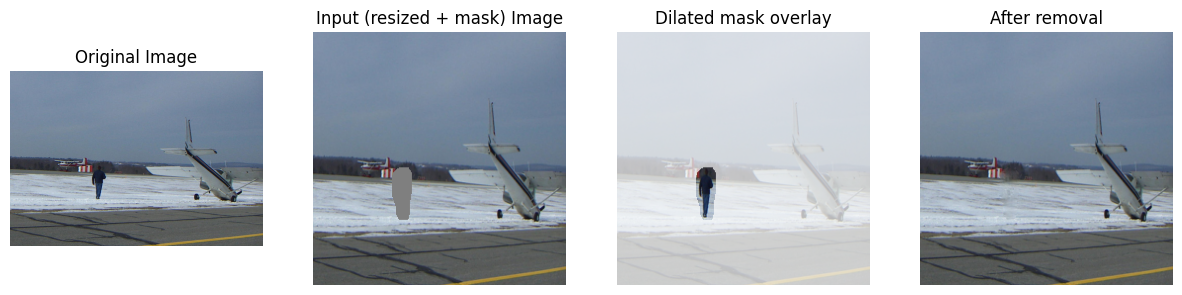

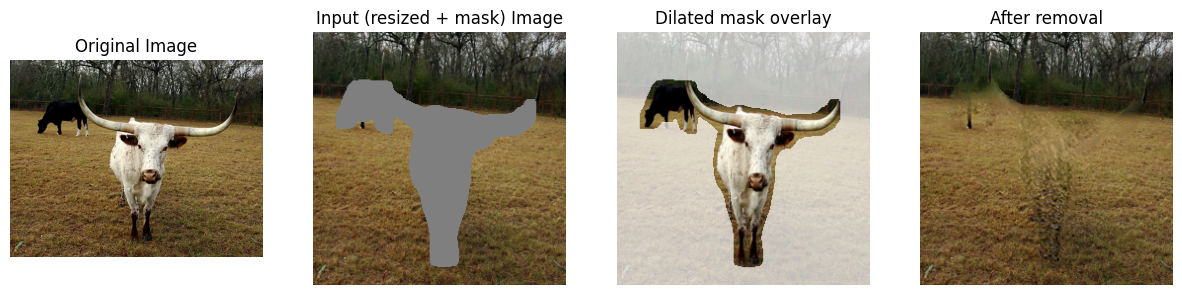

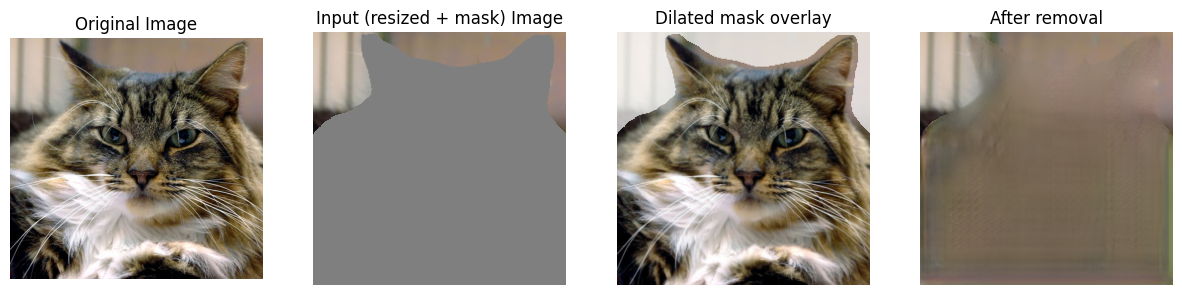

In [56]:
for i, res_img in enumerate(res_imgs):
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(raw_imgs[i])
    ax[0].axis("off")

    ax[1].set_title(f"Input (resized + mask) Image")
    ax[1].imshow(((input_tensors[i] + 1) / 2).cpu().permute(1, 2, 0).numpy())
    ax[1].axis("off")

    ax[2].set_title(f"Dilated mask overlay")
    alpha_mask = np.where(dilated_masks[i].permute(1, 2, 0).cpu().numpy() > 0, 1, 0.3)
    rgba_img = np.concatenate((np.array(resized_imgs[i])/255, alpha_mask), axis=2)
    ax[2].imshow(rgba_img)
    ax[2].axis("off")

    ax[3].set_title(f"After removal")
    ax[3].imshow(res_img.transpose(1, 2, 0))
    ax[3].axis("off")

    plt.show()

## Image after removal

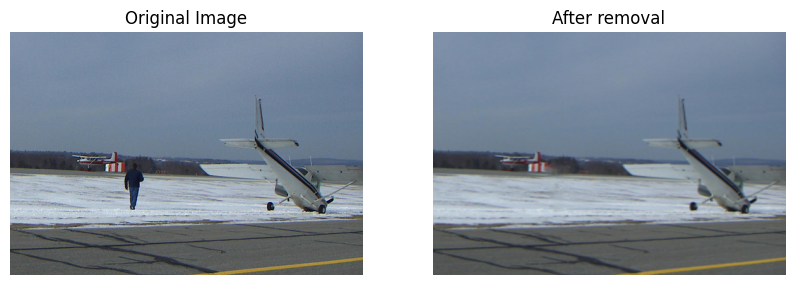

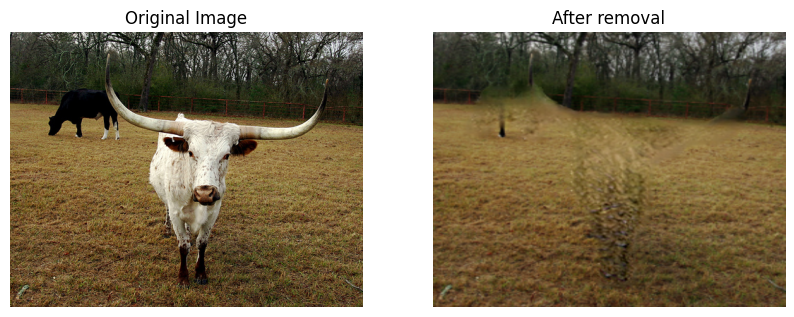

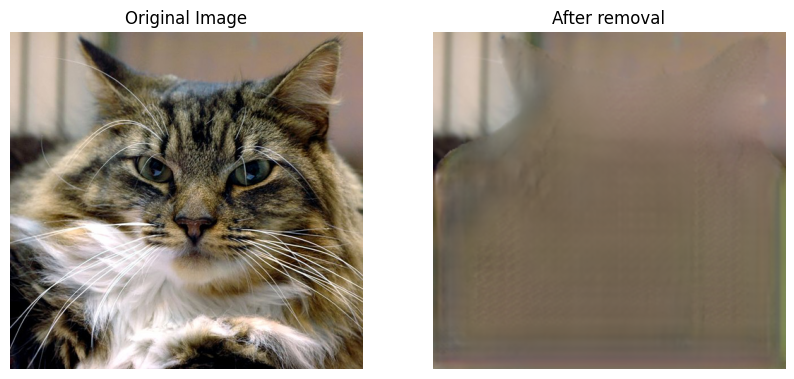

In [57]:
for i, res_img in enumerate(res_imgs):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(raw_imgs[i])
    ax[0].axis("off")

    ax[1].set_title(f"After removal")
    resize_img = transforms.Resize(original_sizes[i][::-1])(torch.tensor(res_img))
    ax[1].imshow(resize_img.permute(1, 2, 0).numpy())
    ax[1].axis("off")
    plt.show()

## Testing by Reusing the Segmentation Model
The output image is feedback to the segmentation model. If the model no longer output the target class, our removal is successful.

In [58]:
input_tensors = []
for res_img in res_imgs:
    processed_tensor = seg_preprocess(np.transpose(res_img, (1, 2, 0)))
    input_tensors.append(processed_tensor)
input_batch = torch.stack(input_tensors).to(device)
# input_batch = torch.tensor(res_imgs).to(device)

with torch.no_grad():
    output = model(input_batch)["out"]
output_predictions = output.argmax(1)

In [65]:
# check that the labels no longer exist
correct = 0
total = len(output_predictions)
for i in range(total):
    res = torch.all(output_predictions[i] != target_classes[i])
    if res:
        correct += 1

print(f"Correctly removed {correct} classes of objects out of {total} Images")


Correctly removed 3 classes of objects out of 3 Images


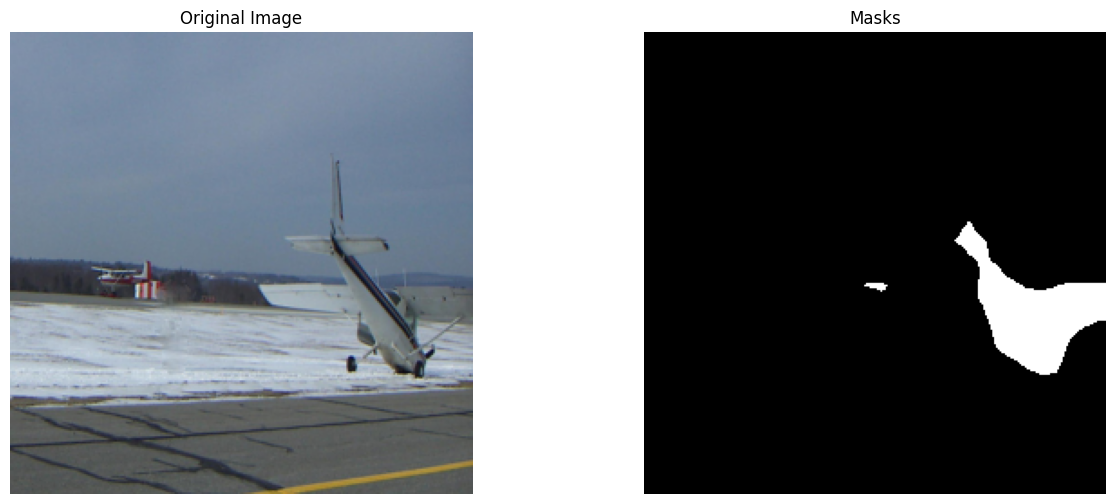

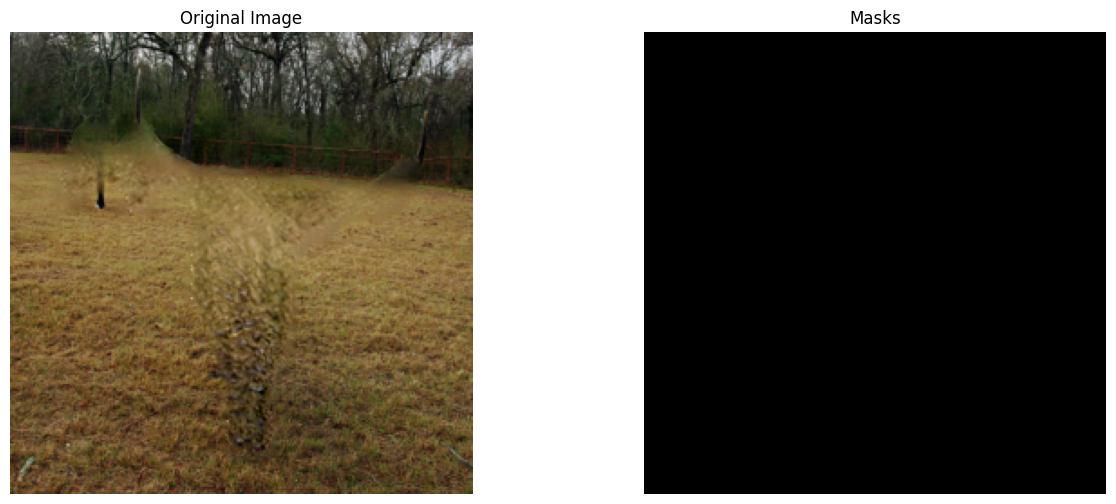

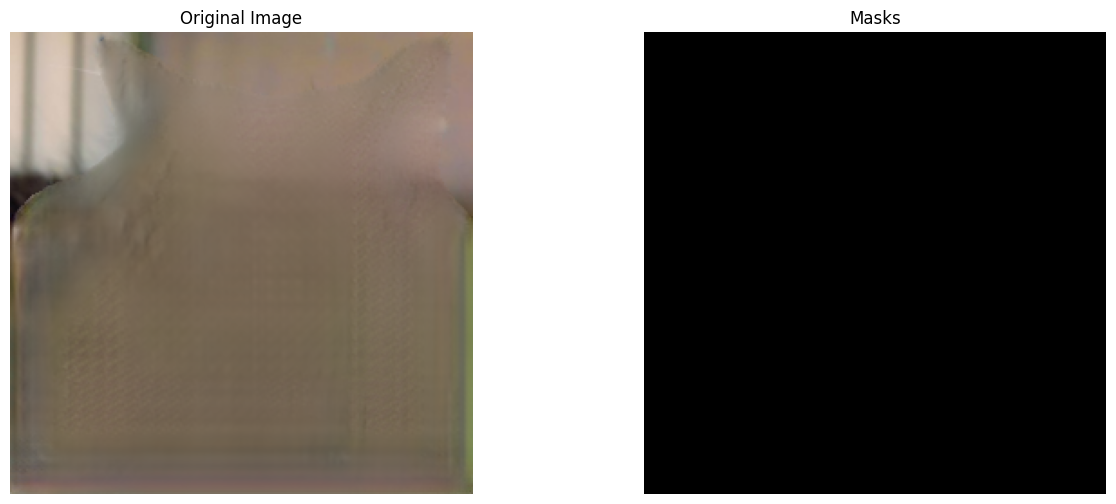

In [63]:
for i, res_img in enumerate(res_imgs):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(np.transpose(res_img, (1, 2, 0)))
    ax[0].axis("off")

    ax[1].set_title(f"Masks")
    mask = output_predictions[i].cpu().numpy()
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis("off")

    plt.show()